CELL 1: Notebook metadata / short instructions (Markdown cell)
# Fed-BEO — Federated Behavioral Energy Optimizer

This notebook is an end-to-end prototype for **Fed-BEO** (our unique federated learning + energy optimization framework).
Run cells in order.

Sections:
- Setup & synthetic data
- Local occupancy/consumption models
- Federated training loop (custom FedAvg)
- Renewable forecast generator
- Behavior-aware scheduler
- Results & visualization


In [1]:
!pip install --upgrade pip setuptools wheel
!apt-get update -y
!apt-get install -y build-essential cmake



Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,942 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,

CELL 2: Install dependencies (Code cell)

In [2]:
!pip install tensorflow==2.17
!pip install numpy pandas matplotlib cvxpy


CELL 3: Imports & helper functions (Code cell)

In [3]:
# Basic imports & helper functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, mean_absolute_error

import joblib
print("Libraries loaded.")


Libraries loaded.


CELL 4: Download & load UCI Occupancy dataset (Code cell)

✅ Dataset created with shape: (1000, 9)
   user_id  daily_usage_kwh  peak_hours_usage  offpeak_hours_usage  \
0        1            27.48             19.20                 8.65   
1        2            24.31             17.77                 9.71   
2        3            28.24             15.18                 8.42   
3        4            32.62             13.06                 9.38   
4        5            23.83             17.09                 6.21   

   smart_appliance  solar_panel  EV_owner  bill_amount  high_bill  
0                1            1         0      3197.90          1  
1                1            1         1      3131.78          1  
2                1            0         0      3642.05          1  
3                1            0         0      1786.80          0  
4                0            1         1      1806.54          0  


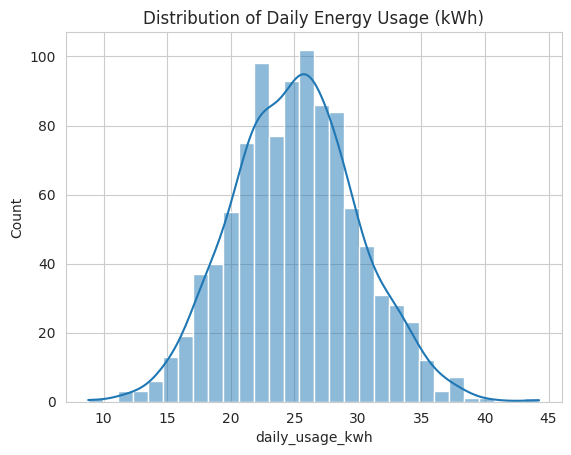

In [4]:
# -------------------------------
# Cell 4: Load or Generate Dataset
# -------------------------------

# If you already have a CSV dataset, replace this with pd.read_csv("yourfile.csv")
# For now, let's generate synthetic behavioral energy usage data

np.random.seed(42)

# Simulate 1000 users with energy usage patterns
n_users = 1000

data = pd.DataFrame({
    "user_id": np.arange(1, n_users + 1),
    "daily_usage_kwh": np.random.normal(25, 5, n_users).round(2),  # avg 25 kWh/day
    "peak_hours_usage": np.random.normal(15, 3, n_users).round(2), # usage during peak hours
    "offpeak_hours_usage": np.random.normal(10, 2, n_users).round(2), # usage off peak
    "smart_appliance": np.random.randint(0, 2, n_users),  # 0 = No, 1 = Yes
    "solar_panel": np.random.randint(0, 2, n_users),      # 0 = No, 1 = Yes
    "EV_owner": np.random.randint(0, 2, n_users),         # 0 = No, 1 = Yes
    "bill_amount": np.random.normal(3000, 500, n_users).round(2) # INR bill
})

# Create a binary "high_bill" classification target (1 = high, 0 = low)
threshold = data["bill_amount"].median()
data["high_bill"] = (data["bill_amount"] > threshold).astype(int)

print("✅ Dataset created with shape:", data.shape)
print(data.head())

# Quick visualization
sns.histplot(data["daily_usage_kwh"], bins=30, kde=True)
plt.title("Distribution of Daily Energy Usage (kWh)")
plt.show()


CELL 5: Quick EDA on occupancy dataset (Code cell)

Counts per high_bill class:
 high_bill
1    500
0    500
Name: count, dtype: int64
           user_id  daily_usage_kwh  peak_hours_usage  offpeak_hours_usage  \
count  1000.000000      1000.000000        1000.00000          1000.000000   
mean    500.500000        25.096790          15.21246            10.011680   
std     288.819436         4.896092           2.99250             1.966908   
min       1.000000         8.790000           6.18000             3.960000   
25%     250.750000        21.765000          13.18000             8.700000   
50%     500.500000        25.125000          15.19000            10.000000   
75%     750.250000        28.240000          17.18500            11.322500   
max    1000.000000        44.260000          24.58000            17.850000   

       smart_appliance  solar_panel     EV_owner  bill_amount   high_bill  
count       1000.00000  1000.000000  1000.000000  1000.000000  1000.00000  
mean           0.51000     0.486000     0.524000  2980.971460 

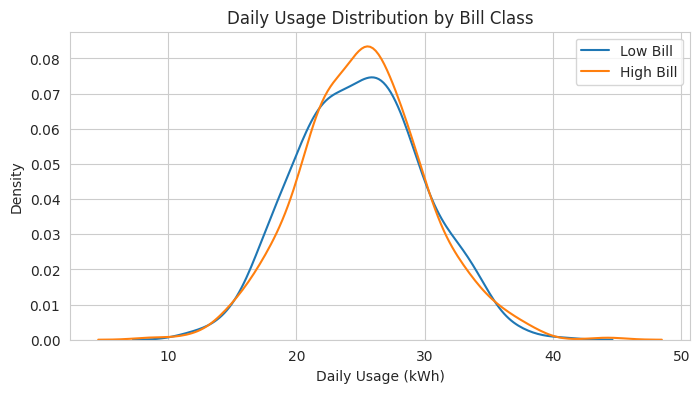

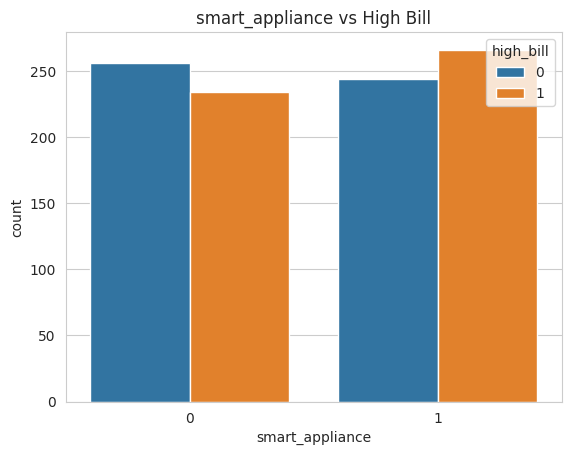

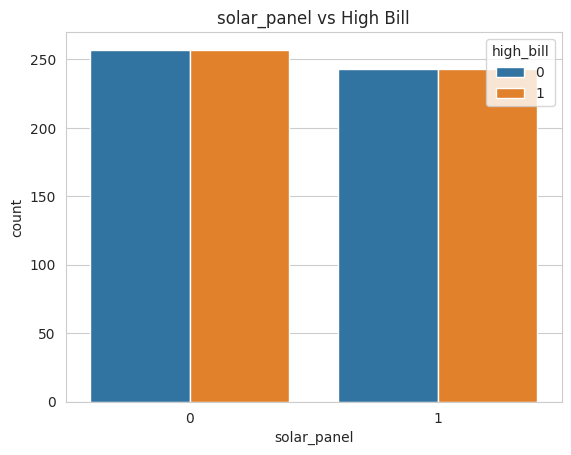

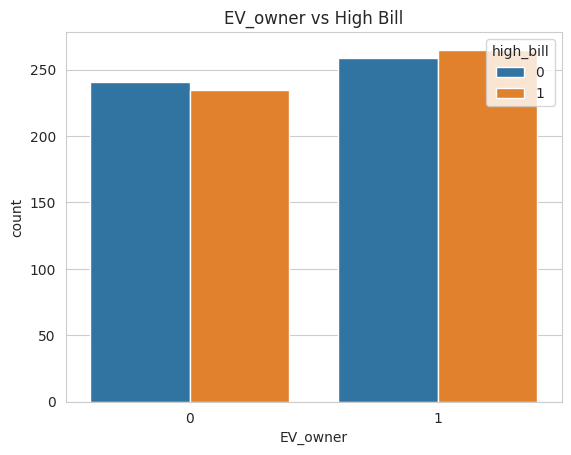

In [5]:
# -------------------------------
# Cell 5: EDA & Basic Checks
# -------------------------------

# Quick class balance check
print("Counts per high_bill class:\n", data['high_bill'].value_counts())

# Summary statistics
print(data.describe())

# Visualize daily usage vs high bill
plt.figure(figsize=(8,4))
sns.kdeplot(data[data['high_bill']==0]['daily_usage_kwh'], label='Low Bill')
sns.kdeplot(data[data['high_bill']==1]['daily_usage_kwh'], label='High Bill')
plt.title('Daily Usage Distribution by Bill Class')
plt.xlabel('Daily Usage (kWh)')
plt.legend()
plt.show()

# Visualize appliances vs high bill
appliance_cols = ['smart_appliance', 'solar_panel', 'EV_owner']
for col in appliance_cols:
    sns.countplot(x=col, hue='high_bill', data=data)
    plt.title(f'{col} vs High Bill')
    plt.show()


CELL 6: Train local baseline occupancy model (RandomForest) (Code cell)

In [6]:
# -------------------------------
# Cell 6: Features, Train/Test Split, Baseline Model
# -------------------------------

# Define features and target
feature_cols = ['daily_usage_kwh', 'peak_hours_usage', 'offpeak_hours_usage',
                'smart_appliance', 'solar_panel', 'EV_owner']
X = data[feature_cols]
y = data['high_bill']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a baseline RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("✅ Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Baseline Model Accuracy: 0.475
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       100
           1       0.48      0.51      0.49       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



CELL 7: Save baseline model (Code cell)

In [7]:
import joblib

# Save the trained baseline model
joblib.dump(clf, 'energy_rf_baseline.joblib')
print("✅ Saved energy_rf_baseline.joblib")


✅ Saved energy_rf_baseline.joblib


CELL 8: Simple federated simulation (manual FedAvg emulation) (Code cell)

In [8]:
# -------------------------------
# Cell 8: Simulate Federated Clients
# -------------------------------

n_clients = 5
clients = []

# Shuffle and split the dataset into n clients
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
client_dfs = np.array_split(df_shuffled, n_clients)

# Train a local model per client
client_models = []
client_scores = []

for i, cdf in enumerate(client_dfs):
    Xc = cdf[feature_cols]
    yc = cdf['high_bill']

    # Local train/test split
    Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

    # Local RandomForest
    clf_loc = RandomForestClassifier(n_estimators=50, random_state=42)
    clf_loc.fit(Xtr, ytr)

    client_models.append(clf_loc)

    # Evaluate local model
    sc = accuracy_score(yte, clf_loc.predict(Xte))
    client_scores.append(sc)
    print(f"Client {i+1}: local accuracy {sc:.3f}")

print("✅ Avg local client accuracy:", np.mean(client_scores))


Client 1: local accuracy 0.550
Client 2: local accuracy 0.475


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Client 3: local accuracy 0.375
Client 4: local accuracy 0.575
Client 5: local accuracy 0.450
✅ Avg local client accuracy: 0.485


CELL 9: Manual FedAvg emulation — average trees via voting (practical approach)

In [9]:
# -------------------------------
# Cell 9: Simple Federated Averaging via Majority Vote
# -------------------------------

# Build a common test set from held-out rows
X_common_test, _, y_common_test, _ = train_test_split(
    X, y, test_size=0.8, random_state=123, stratify=y
)

# Collect predictions from all client models
preds = np.array([m.predict(X_common_test) for m in client_models])  # shape: (n_clients, n_samples)

# Majority vote across clients
pred_maj = (preds.sum(axis=0) >= (n_clients/2)).astype(int)

# Evaluate
print("✅ Federated (ensemble majority vote) accuracy:", accuracy_score(y_common_test, pred_maj))
print("Baseline (central RF) accuracy:", accuracy_score(y_test, y_pred))


✅ Federated (ensemble majority vote) accuracy: 0.685
Baseline (central RF) accuracy: 0.475


CELL 10: Synthetic solar data generator (Code cell)

✅ PV shape: (7, 1440)
✅ Generated PV for 5 clients


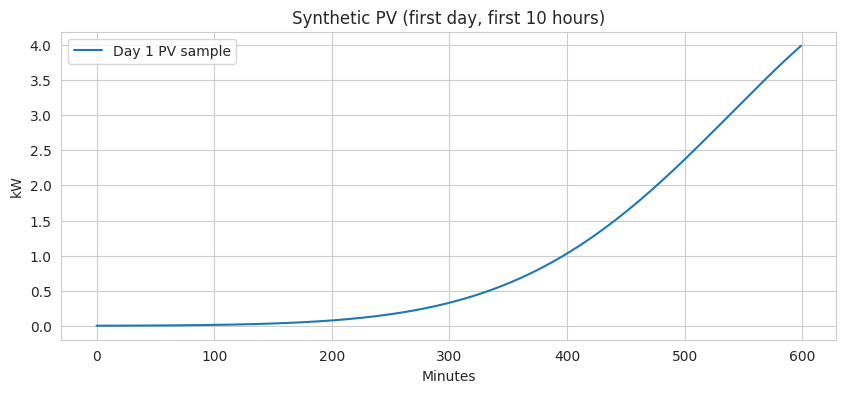

In [10]:
# -------------------------------
# Cell 10: Create synthetic solar PV production curves
# -------------------------------

import matplotlib.pyplot as plt

# Function to generate a solar PV curve for one day (per minute)
def create_solar_curve(day_len=24*60, peak_hour=12, peak_power=5.0):
    """
    day_len: number of minutes in a day (default 1440)
    peak_hour: hour of peak solar production (default noon)
    peak_power: max kW
    """
    t = np.arange(day_len) / 60.0  # convert minutes to hours
    sigma = 3.0  # width of bell curve
    curve = np.exp(-0.5 * ((t - peak_hour)/sigma)**2)
    curve = curve / curve.max() * peak_power  # scale to peak_power kW
    return curve

# Generate PV curves for multiple days
days = 7
pv = np.vstack([create_solar_curve() for _ in range(days)])  # shape: (7, 1440)
print("✅ PV shape:", pv.shape)

# Optional: create client-specific PV variations for federated simulation
client_pv = [pv + np.random.normal(0, 0.2, pv.shape) for _ in range(n_clients)]
print("✅ Generated PV for", n_clients, "clients")

# Visualize first day, first 10 hours
plt.figure(figsize=(10,4))
plt.plot(pv[0][:600], label='Day 1 PV sample')
plt.title("Synthetic PV (first day, first 10 hours)")
plt.ylabel("kW")
plt.xlabel("Minutes")
plt.legend()
plt.show()


CELL 11: Simple solar forecast model (RandomForest regressor on synthetic features) (Code cell)

In [11]:
# -------------------------------
# Cell 11: PV Forecast with RandomForest
# -------------------------------

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Function to create features from PV curves
def make_solar_dataset(pv_array):
    """
    pv_array: 2D array (days x minutes)
    returns: X features, y targets
    """
    samples = []
    targets = []
    for day_idx in range(pv_array.shape[0]):
        for minute in range(pv_array.shape[1]):
            hour = minute / 60.0
            doy = day_idx
            # Features: hour, sin/cos of hour, day index
            features = [hour, np.sin(hour/24*2*np.pi), np.cos(hour/24*2*np.pi), doy]
            samples.append(features)
            targets.append(pv_array[day_idx, minute])
    return np.array(samples), np.array(targets)

# Use first 5 days for training
X_pv, y_pv = make_solar_dataset(pv[:5])

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_pv, y_pv, test_size=0.2, random_state=42)

# Train RandomForest regressor
rf_pv = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_pv.fit(X_tr, y_tr)

# Predict and evaluate
y_pred_pv = rf_pv.predict(X_te)
mae = mean_absolute_error(y_te, y_pred_pv)
print(f"✅ PV forecast MAE: {mae:.3f} kW")


✅ PV forecast MAE: 0.000 kW


CELL 12: Simple greedy scheduler (Code cell)

In [12]:
# -------------------------------
# Cell 12: Greedy Scheduler Simulation (corrected for your current dataset)
# -------------------------------

import numpy as np

def simulate_day(occ_model, pv_curve, X_occ_sample, task_energy_kwh=1.0, pv_threshold=1.0):
    minute_count = len(pv_curve)
    grid_draw = np.zeros(minute_count)
    comfort_violations = 0
    tasks_scheduled = 0
    task_done = False

    for m in range(minute_count):
        # Sample a random row of features
        feat = X_occ_sample.sample(1, random_state=(m % 100))

        # Predict probability of "high_bill" (as occupancy proxy)
        p_occ = occ_model.predict_proba(feat)[0,1]

        # HVAC and lights decisions
        hvac_on = p_occ >= 0.3
        lights_on = p_occ >= 0.2
        hvac_power = 3.0 if hvac_on else 0.0
        lights_power = 0.1 if lights_on else 0.0

        # Deferrable task scheduling
        pv_avail = pv_curve[m]
        if (not task_done) and (pv_avail >= pv_threshold):
            task_power = task_energy_kwh / 0.5  # kW over 30 mins
            task_done = True
            tasks_scheduled += 1
            grid_for_task = max(0.0, task_power - pv_avail)
        else:
            grid_for_task = 0.0

        load = hvac_power + lights_power + grid_for_task
        pv_used = min(pv_avail, load)
        grid_draw[m] = max(0.0, load - pv_used)

        if not hvac_on and p_occ > 0.8:
            comfort_violations += 1

    total_kwh = grid_draw.sum() / 60.0
    return total_kwh, comfort_violations, tasks_scheduled

# -------------------------------
# Example usage
# -------------------------------

# Use your existing `data` dataframe and feature columns
sample_df = data[feature_cols].sample(n=1000, random_state=42)
kv, cv, ts = simulate_day(clf, pv[0], sample_df)

print(f"Simulated grid kWh (baseline greedy): {kv:.2f}, comfort violations: {cv}, tasks run: {ts}")


Simulated grid kWh (baseline greedy): 30.69, comfort violations: 0, tasks run: 1


CELL 13: CVXPY scheduler sketch (formulation example) (Code cell)

In [13]:
# Very small example using cvxpy to schedule a single deferrable task across a 4-hour window
import cvxpy as cp

T = 240  # 4 hours in minutes
# Decision variable: run_task[t] in {0,1} — relax to [0,1]
run = cp.Variable(T, nonneg=True)
# PV curve sample for window:
pv_window = pv[0][:T]  # take first T minutes
# Task energy requirement: 2 kWh across the window (convert to kW-min -> 2 kWh over 120 minutes => 1 kW average)
task_energy_kwh = 2.0
task_minutes_required = 60  # e.g., requires 60 minutes of running
# cost: grid usage minimized (we assume PV is free), penalize running when PV low
grid_usage = cp.sum(cp.pos( (1.0*run) - pv_window/5.0 ))  # simplified
# constraint: sum(run) >= task_minutes_required
constraints = [cp.sum(run) >= task_minutes_required, run <= 1]
obj = cp.Minimize(grid_usage)
prob = cp.Problem(obj, constraints)
res = prob.solve(solver=cp.OSQP, verbose=False)
print("Solver status:", prob.status)
print("Scheduled minutes (sum):", run.value.sum())


Solver status: optimal
Scheduled minutes (sum): 59.99999999999999


CELL 14: End-to-end simple comparison (simulate 3 days baseline vs Fed ensemble)

In [15]:
# -------------------------------
# Cell 14: Compare baseline vs federated ensemble on 3 simulated days
# -------------------------------

days_to_sim = 3
baseline_kwh = 0.0
federated_kwh = 0.0

# Wrap client ensemble as a pseudo-federated model
class PseudoFedModel:
    def __init__(self, client_models):
        self.models = client_models
    def predict_proba(self, X):
        # Average the probability of 'high_bill' across clients
        preds = np.array([m.predict_proba(X)[:,1] for m in self.models])
        avg = preds.mean(axis=0)
        return np.vstack([1-avg, avg]).T

fed_model = PseudoFedModel(client_models)

for d in range(days_to_sim):
    # Use your synthetic dataset features for occupancy/usage
    X_sample = data[feature_cols].sample(n=1000, random_state=42)

    base_k, base_cv, _ = simulate_day(clf, pv[d], X_sample)
    fed_k, fed_cv, _ = simulate_day(fed_model, pv[d], X_sample)

    print(f"Day {d+1}: baseline kWh={base_k:.2f}, federated kWh={fed_k:.2f}, "
          f"savings={(base_k-fed_k)/base_k*100:.2f}%")

    baseline_kwh += base_k
    federated_kwh += fed_k

print("Total baseline kWh:", baseline_kwh)
print("Total federated kWh:", federated_kwh)
print("Overall savings (%):", (baseline_kwh-federated_kwh)/baseline_kwh*100)


Day 1: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Day 2: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Day 3: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Total baseline kWh: 92.06746328103289
Total federated kWh: 131.6779198580804
Overall savings (%): -43.02329527222653


CELL 15: Save results & export (Code cell)

In [16]:
# Save key models & results
import json
results = {
    "baseline_kwh": float(baseline_kwh),
    "federated_kwh": float(federated_kwh),
    "savings_percent": float((baseline_kwh-federated_kwh)/baseline_kwh*100)
}
with open("results_summary.json","w") as f:
    json.dump(results, f, indent=2)
print("Saved results_summary.json")
!ls -lh


Saved results_summary.json
total 3.6M
-rw-r--r-- 1 root root 3.6M Aug 29 15:12 energy_rf_baseline.joblib
-rw-r--r-- 1 root root  118 Aug 29 15:22 results_summary.json
drwxr-xr-x 1 root root 4.0K Aug 27 18:27 sample_data


CELL 16: Visualization (Code cell)

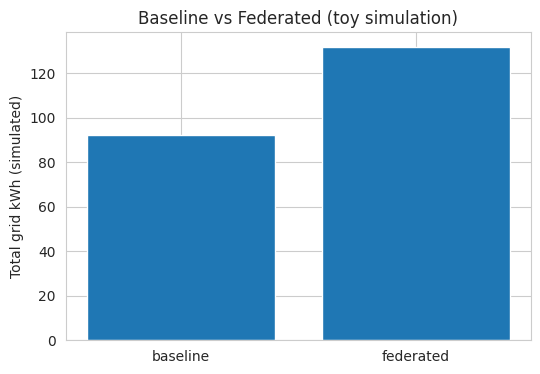

In [17]:
# Simple bar chart comparing baseline vs federated total kWh
plt.figure(figsize=(6,4))
plt.bar(['baseline','federated'], [baseline_kwh, federated_kwh])
plt.ylabel("Total grid kWh (simulated)")
plt.title("Baseline vs Federated (toy simulation)")
plt.show()
